In [ ]:
print("hi")

hi


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00


PROFESSIONAL PER-DISH TIME SERIES FORECASTING ANALYSIS

Analysis Start Time: 2025-10-12 04:15:44
CatBoost Available: True

SECTION 1: DATA LOADING AND PREPROCESSING

Step 1.1: Loading raw data...
Initial data shape: (155599, 36)
Initial columns: ['date', 'year', 'month', 'weekday', 'is_weekend', 'season', 'climate', 'is_holiday', 'holiday_religion', 'is_festival', 'working_day', 'restaurant_id', 'restaurant_name', 'restaurant_locality', 'restaurant_demand_multiplier', 'food_name', 'category', 'veg_nonveg', 'ingredient', 'foodtype', 'meal_type', 'hot_cold', 'is_milkbased', 'solid_liquid', 'spice_level', 'size', 'is_chefspecial', 'dish_popularity', 'rating', 'price_per_unit', 'price_mean', 'base_low', 'base_mid', 'base_high', 'units_sold', 'revenue']

Step 1.2: Removing unnecessary columns...
Columns after removal: 29

Step 1.3: Propagating food-level attributes...
Propagated 13 food-level attributes

Step 1.4: Handling missing values...
Missing values imputed: 0
Remaining missing values

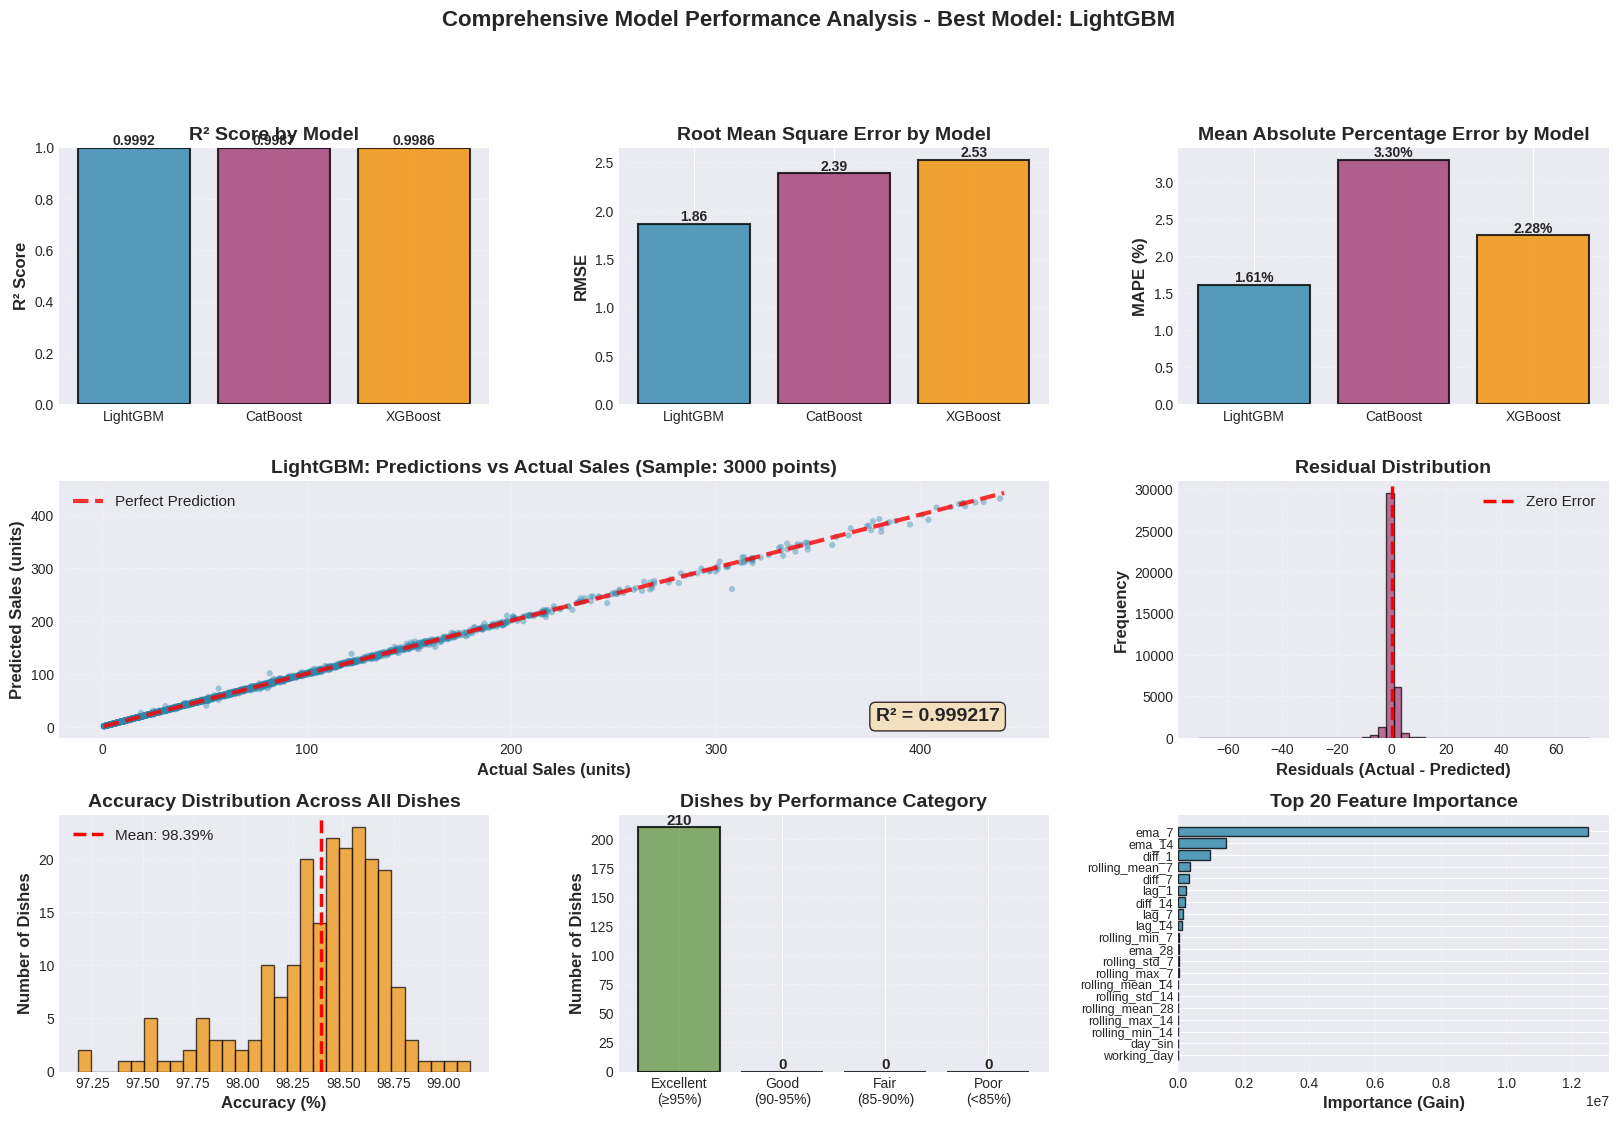


Generating Figure 2: Time Series for Top 5 Dishes...
Saved: figure2_top5_timeseries.png


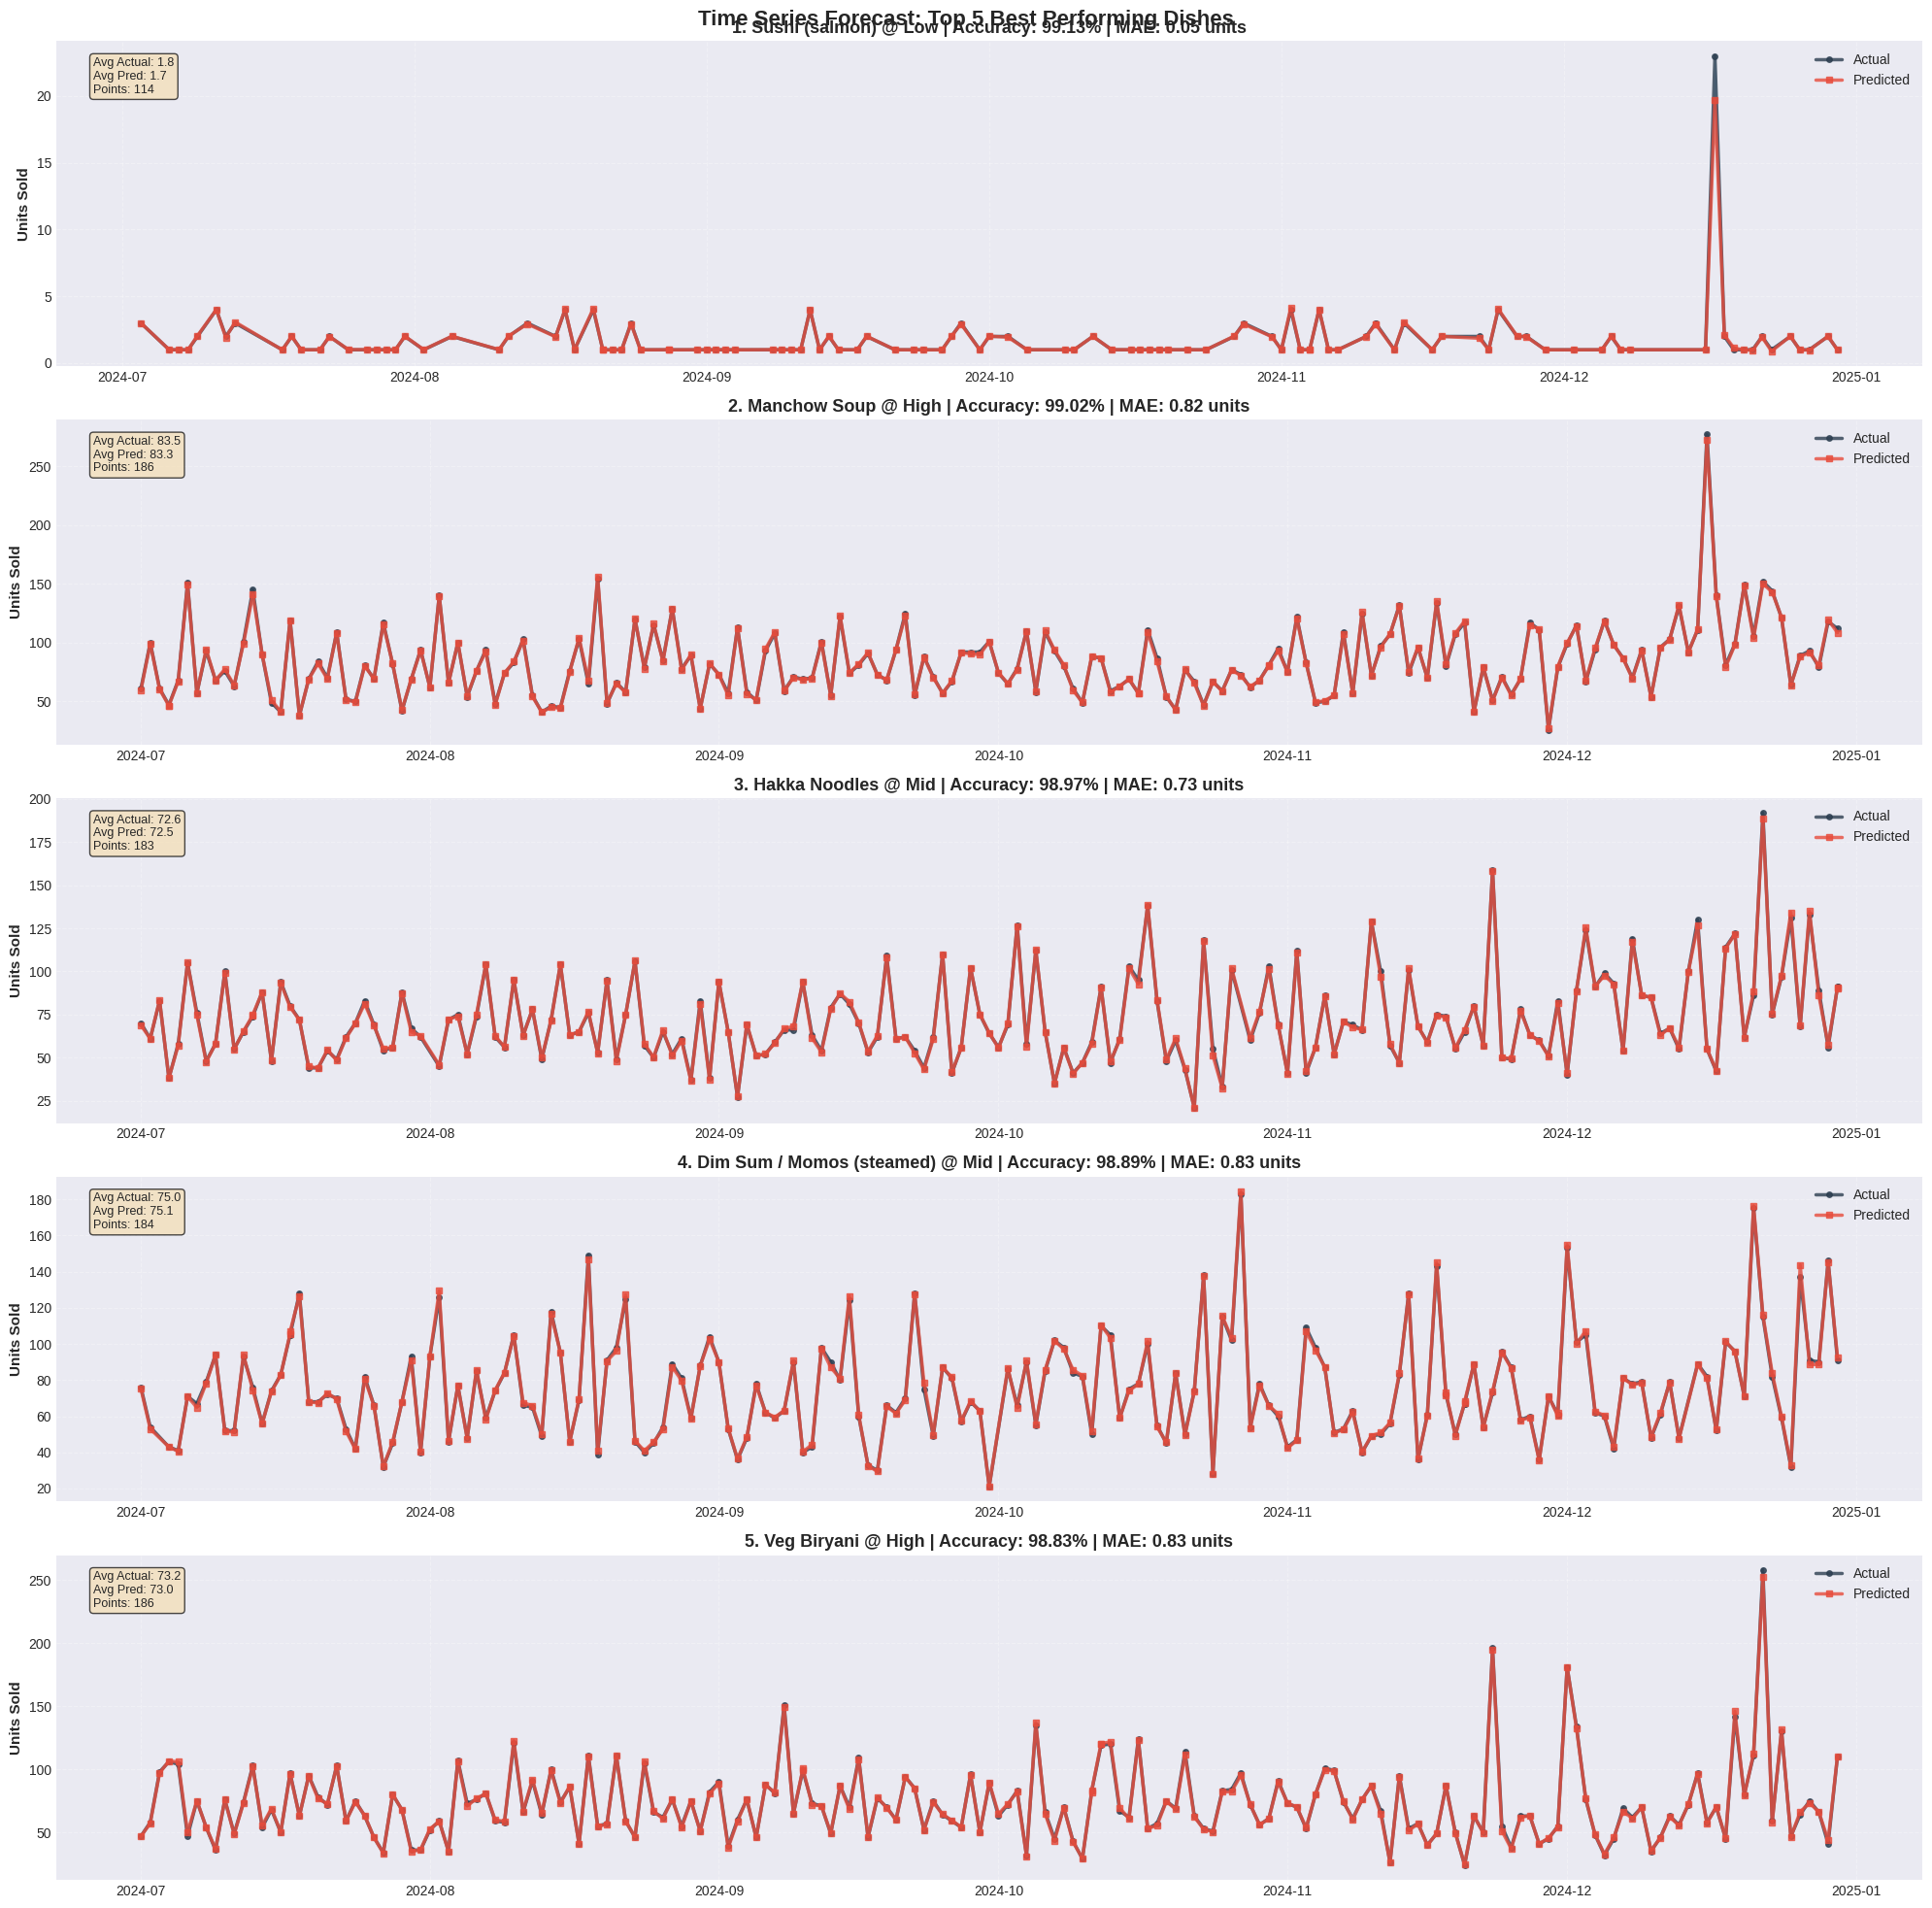


Generating Figure 3: Time Series for Bottom 5 Dishes...
Saved: figure3_bottom5_timeseries.png


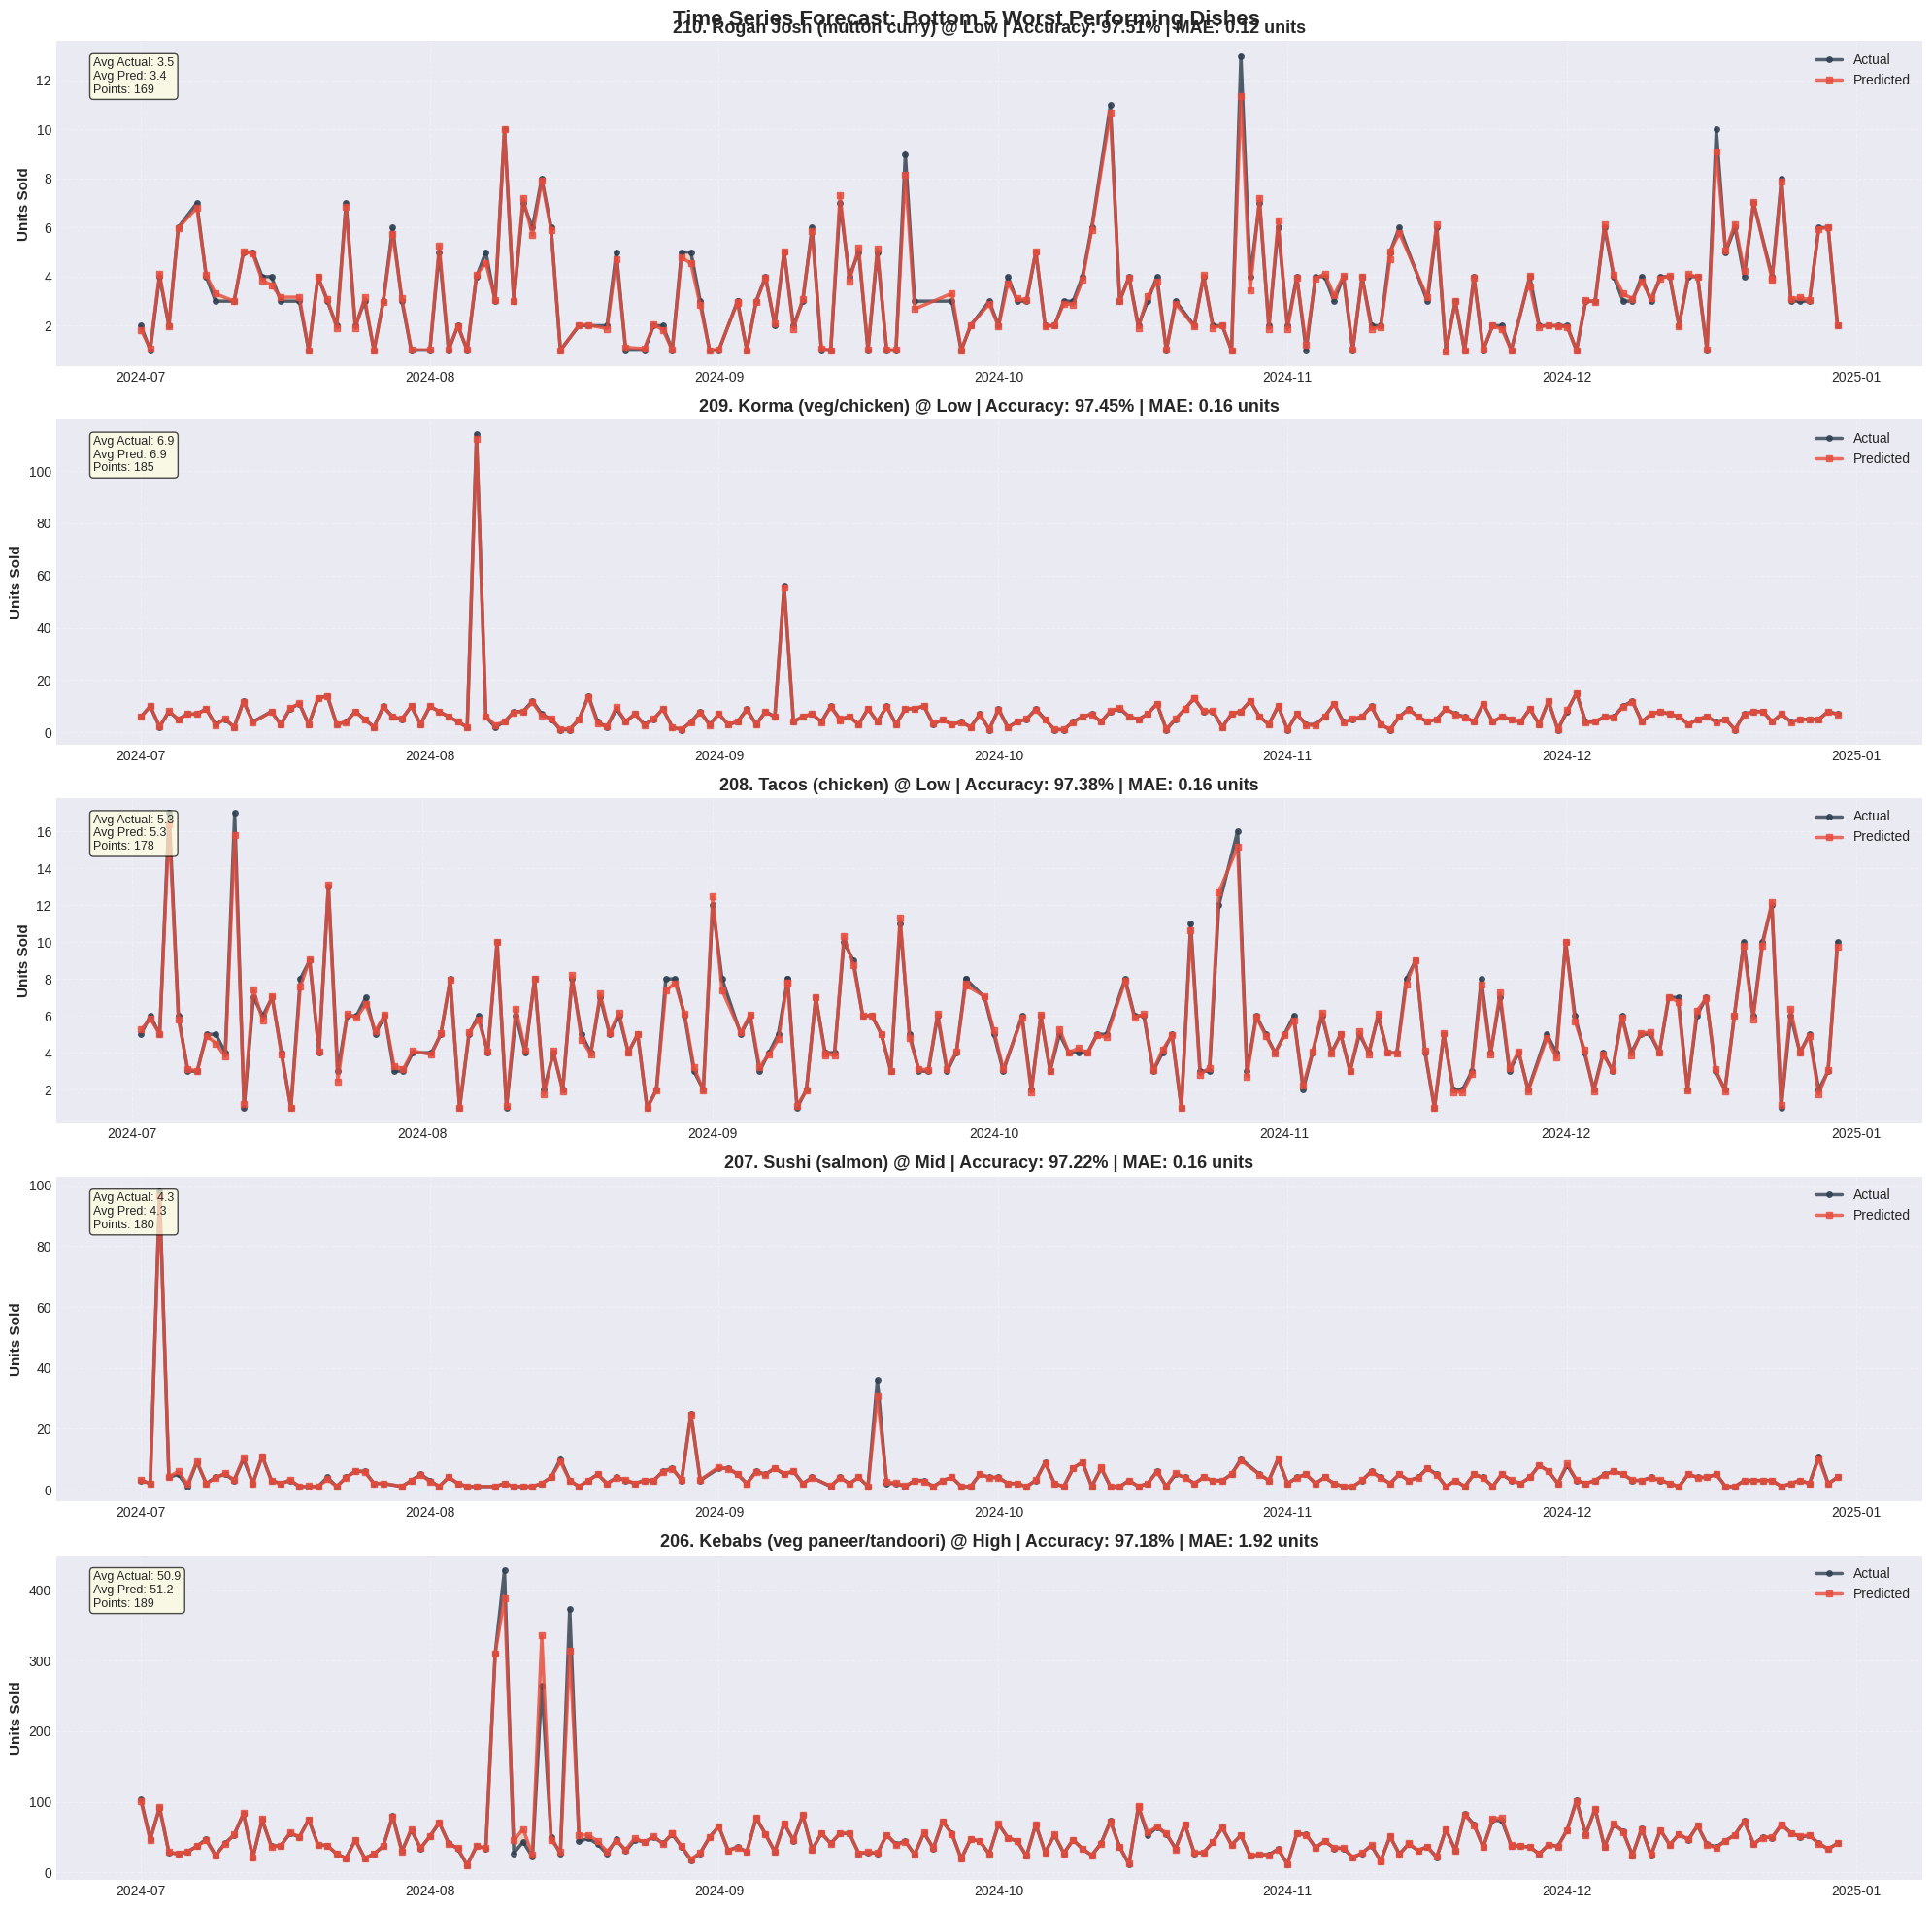


Generating Figure 4: Overall Daily Aggregated Forecast...
Saved: figure4_overall_daily_forecast.png


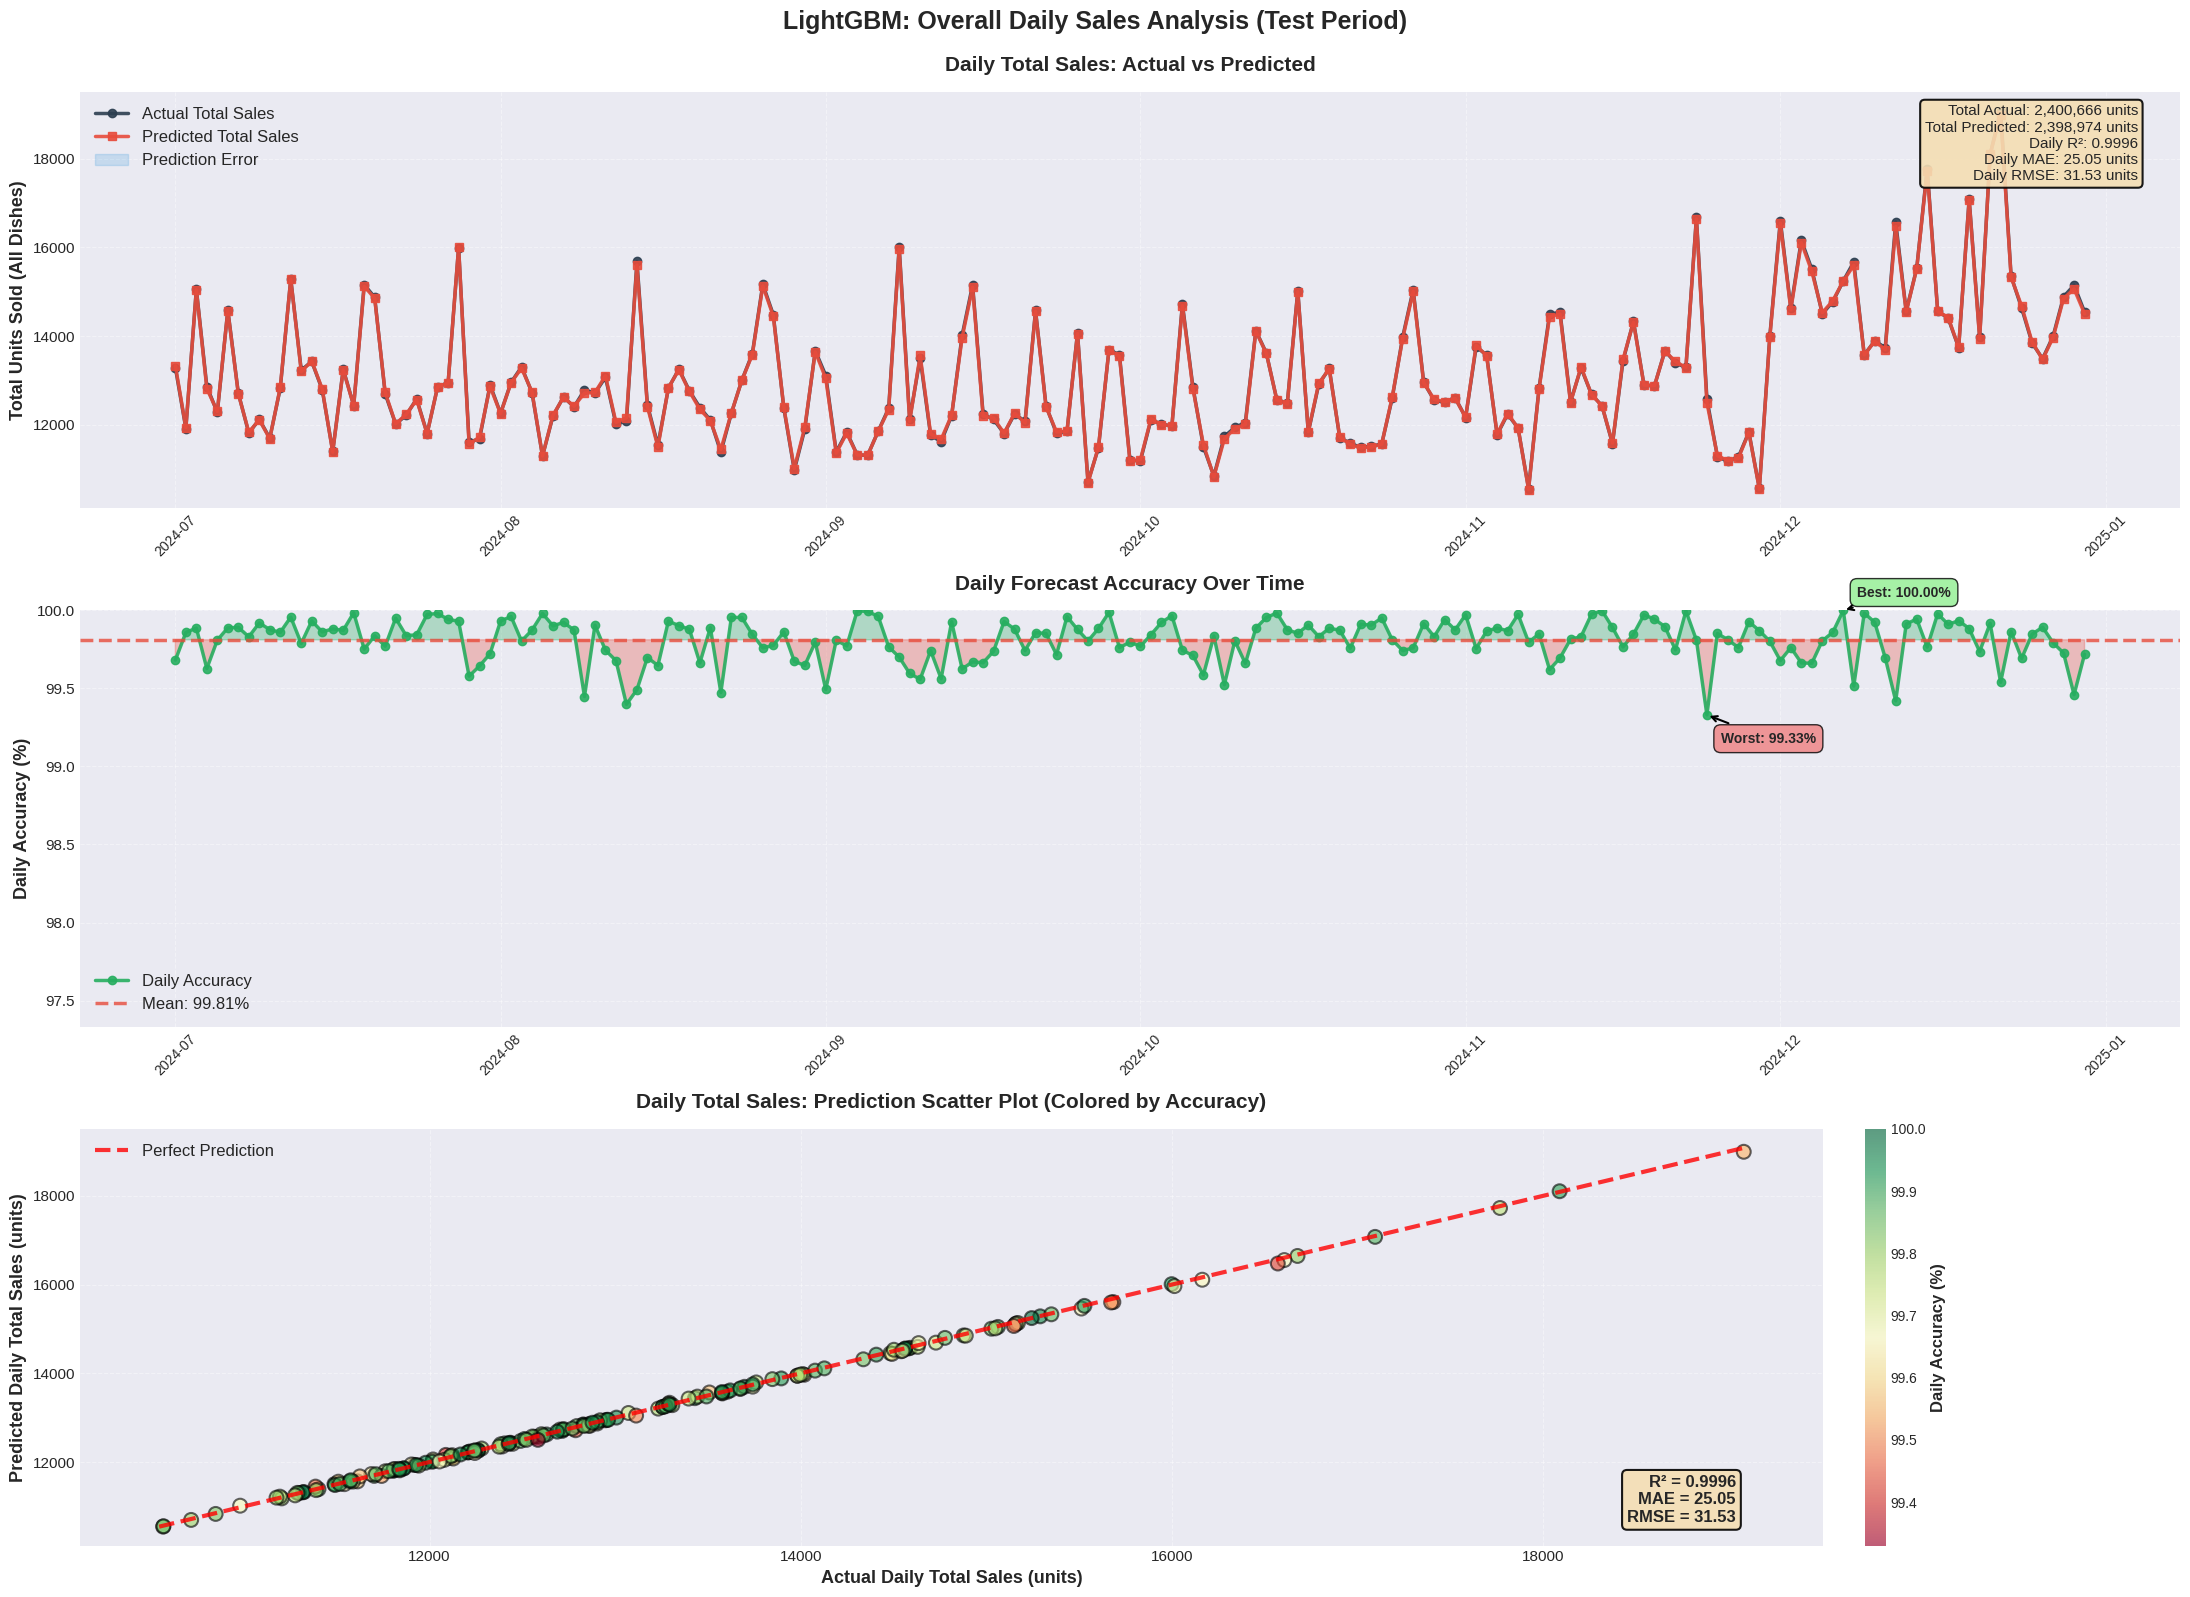


Generating Figure 5: Simple Daily Sales Comparison...
Saved: figure5_simple_daily_comparison.png


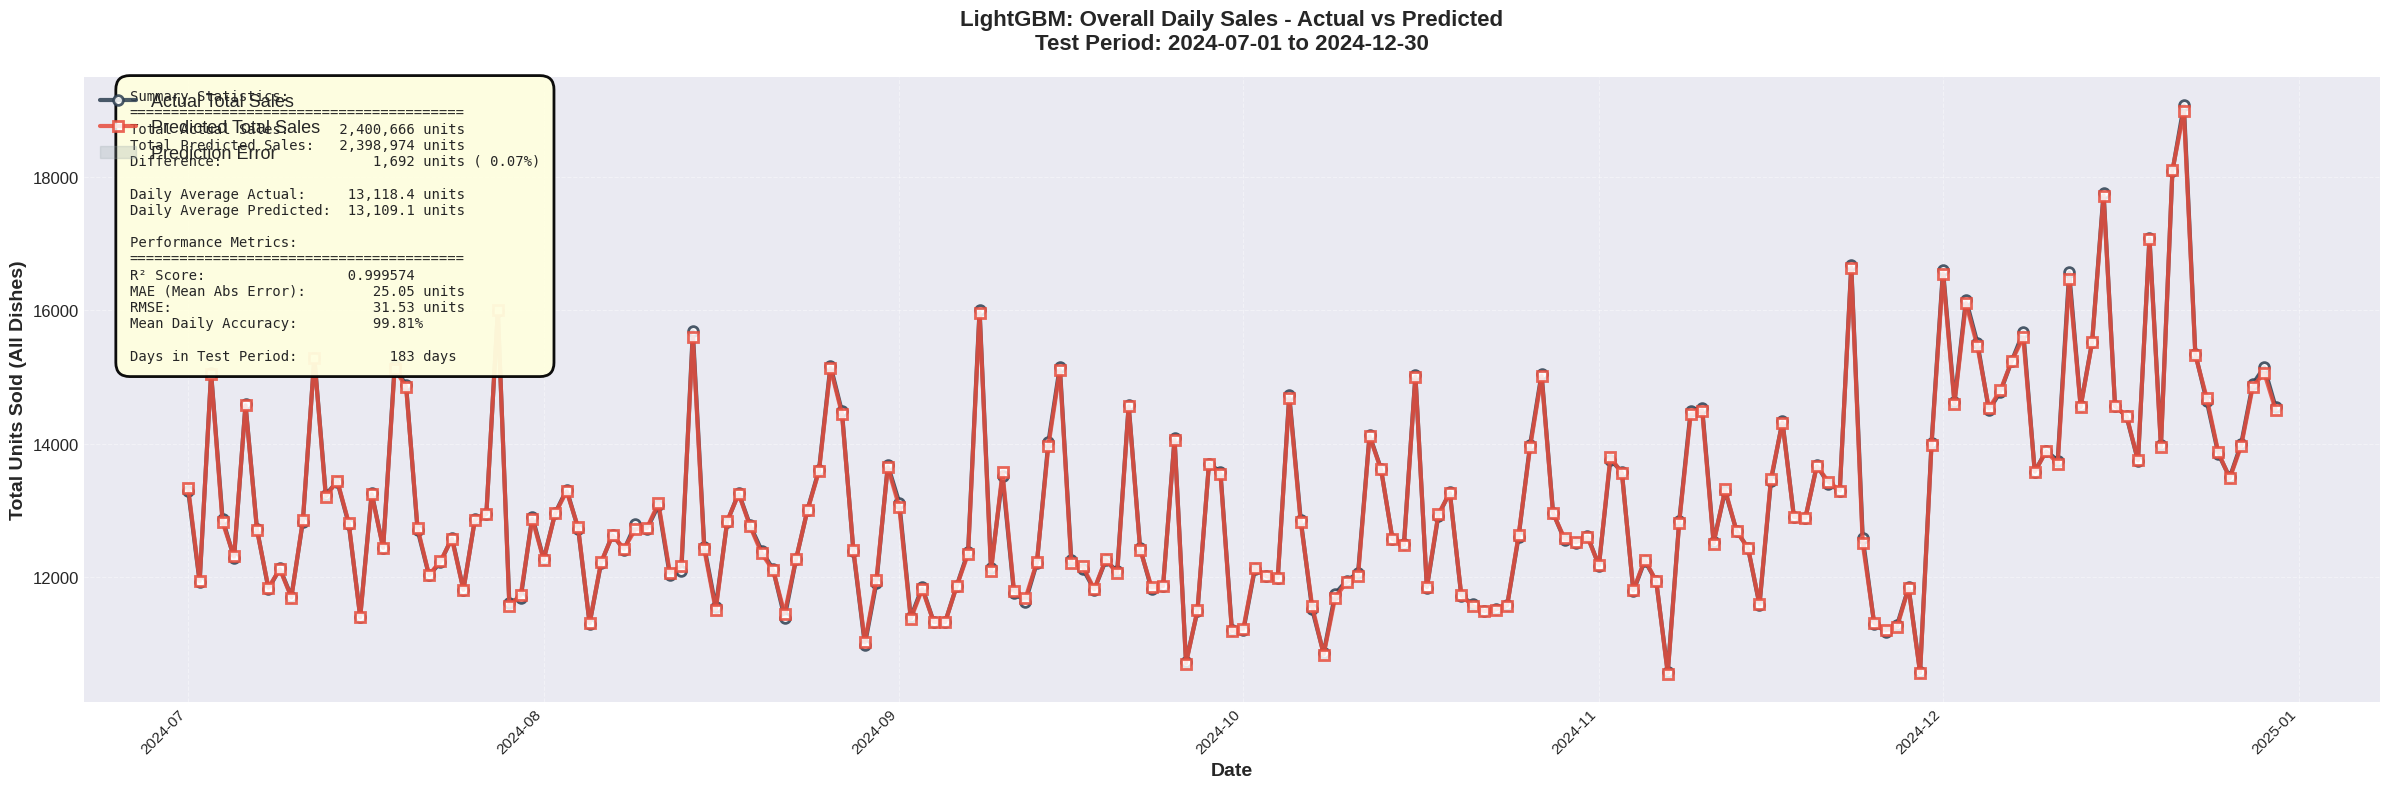


SECTION 9: FINAL SUMMARY AND VALIDATION

TRAINING AND TESTING PERIODS:
  Training: 2023-01-27 00:00:00 to 2024-06-30 00:00:00 (520 days)
  Testing:  2024-07-01 00:00:00 to 2024-12-30 00:00:00 (182 days)

DATA LEAKAGE CHECK:
  Training end date: 2024-06-30 00:00:00
  Testing start date: 2024-07-01 00:00:00
  Gap: 1 days
  Status: NO DATA LEAKAGE - Proper time-based split

MODEL PERFORMANCE SUMMARY:

LightGBM:
  R² Score: 0.999217
  RMSE: 1.8631
  MAE: 0.9008
  MAPE: 1.6136%
  Accuracy (±20%): 99.8330%

CatBoost:
  R² Score: 0.998715
  RMSE: 2.3871
  MAE: 1.2524
  MAPE: 3.2958%
  Accuracy (±20%): 98.4811%

XGBoost:
  R² Score: 0.998561
  RMSE: 2.5262
  MAE: 1.1469
  MAPE: 2.2753%
  Accuracy (±20%): 99.5146%

PER-DISH PERFORMANCE:
  Total dishes analyzed: 210
  Average accuracy: 98.39%
  Median accuracy: 98.46%
  Best dish accuracy: 99.13%
  Worst dish accuracy: 97.18%
  Dishes with >95% accuracy: 210
  Dishes with >90% accuracy: 210

KEY INSIGHTS:
  1. Best model: LightGBM with R² = 0.9

In [ ]:
"""
PROFESSIONAL PER-DISH TIME SERIES FORECASTING ANALYSIS
========================================================
Author: Time Series Forecasting System
Date: 2024

Objective:
    Forecast daily sales for each dish-restaurant combination using
    distribution-aware machine learning models.

Models Evaluated:
    1. LightGBM with Tweedie loss
    2. XGBoost with Poisson loss
    3. CatBoost with RMSE loss

Training Period: 2023-01-01 to 2024-06-30 (18 months)
Testing Period:  2024-07-01 to 2024-12-30 (6 months)

Expected Output:
    - Model comparison metrics
    - Per-dish performance analysis
    - Time series visualizations for top/bottom performers
    - Feature importance analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import lightgbm as lgb
import xgboost as xgb

# Attempt to import CatBoost
try:
    from catboost import CatBoostRegressor, Pool
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("WARNING: CatBoost not available. Install with: pip install catboost")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*100)
print("PROFESSIONAL PER-DISH TIME SERIES FORECASTING ANALYSIS")
print("="*100)
print(f"\nAnalysis Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"CatBoost Available: {CATBOOST_AVAILABLE}")

# ============================================================================
# SECTION 1: DATA LOADING AND PREPROCESSING
# ============================================================================
print("\n" + "="*100)
print("SECTION 1: DATA LOADING AND PREPROCESSING")
print("="*100)

print("\nStep 1.1: Loading raw data...")
df = pd.read_csv("/content/food_sales_raw.csv")
print(f"Initial data shape: {df.shape}")
print(f"Initial columns: {list(df.columns)}")

print("\nStep 1.2: Removing unnecessary columns...")
columns_to_drop = ['restaurant_id', 'restaurant_name', 'price_per_unit',
                   'base_low', 'base_mid', 'base_high', 'revenue']
df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
print(f"Columns after removal: {df.shape[1]}")

print("\nStep 1.3: Propagating food-level attributes...")
food_columns = ['rating', 'price_mean', 'solid_liquid', 'spice_level', 'veg_nonveg',
                'ingredient', 'foodtype', 'meal_type', 'hot_cold', 'is_milkbased',
                'is_chefspecial', 'dish_popularity', 'category']

for col in food_columns:
    df[col] = df.groupby('food_name')[col].transform('first')
print(f"Propagated {len(food_columns)} food-level attributes")

print("\nStep 1.4: Handling missing values...")
# Climate imputation based on season
season_to_climate = {
    'Rainy': 'Rainy',
    'Summer': 'Hot',
    'Autumn': 'Cool',
    'Winter': 'Cold'
}
df['climate'] = df.apply(lambda row: season_to_climate.get(row['season'], row['climate']), axis=1)
df['holiday_religion'].fillna('NO', inplace=True)

# Numeric columns: median imputation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
missing_before = df[numeric_columns].isnull().sum().sum()
for col in numeric_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical columns: mode imputation
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print(f"Missing values imputed: {missing_before}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

print("\nStep 1.5: Removing outliers using percentile method...")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
lower_percentile = df[numeric_cols].quantile(0.01)
upper_percentile = df[numeric_cols].quantile(0.99)
rows_before = len(df)
for col in numeric_cols:
    df = df[(df[col] >= lower_percentile[col]) & (df[col] <= upper_percentile[col])]
rows_removed = rows_before - len(df)
print(f"Rows before outlier removal: {rows_before:,}")
print(f"Rows after outlier removal: {len(df):,}")
print(f"Rows removed: {rows_removed:,} ({rows_removed/rows_before*100:.2f}%)")

print("\nStep 1.6: Creating series identifier...")
df['date'] = pd.to_datetime(df['date'])
df['series_id'] = df['food_name'] + ' @ ' + df['restaurant_locality']
unique_series = df['series_id'].nunique()
unique_foods = df['food_name'].nunique()
unique_localities = df['restaurant_locality'].nunique()

print(f"Total unique time series: {unique_series}")
print(f"Unique foods: {unique_foods}")
print(f"Unique localities: {unique_localities}")
print(f"Expected series (foods × localities): {unique_foods * unique_localities}")

print("\nStep 1.7: Sorting data...")
df = df.sort_values(['series_id', 'date']).reset_index(drop=True)
print(f"Data sorted by series_id and date")

print("\nStep 1.8: Data summary statistics...")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")
print(f"Target variable (units_sold) statistics:")
print(f"  Mean: {df['units_sold'].mean():.2f}")
print(f"  Median: {df['units_sold'].median():.2f}")
print(f"  Std: {df['units_sold'].std():.2f}")
print(f"  Min: {df['units_sold'].min():.0f}")
print(f"  Max: {df['units_sold'].max():.0f}")

# ============================================================================
# SECTION 2: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*100)
print("SECTION 2: FEATURE ENGINEERING")
print("="*100)

print("\nStep 2.1: Creating temporal features...")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['day_of_month'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
print("Created 7 temporal features")

print("\nStep 2.2: Creating cyclical encodings...")
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
print("Created 6 cyclical features")

print("\nStep 2.3: Creating distribution-aware features...")
# Seasonal wave (matching data generation)
df['month_normalized'] = (df['month'] - 1) / 12.0
df['seasonal_wave'] = 0.15 * np.sin(2 * np.pi * df['month_normalized'])

# Climate-food matching effect
df['climate_match'] = 1.0
summer_cold = (df['season'] == 'Summer') & ((df['is_milkbased'] == 1) | (df['hot_cold'] == 'cold'))
winter_hot = (df['season'] == 'Winter') & (df['hot_cold'] == 'hot')
df.loc[summer_cold, 'climate_match'] = 1.35 + df.loc[summer_cold, 'seasonal_wave']
df.loc[winter_hot, 'climate_match'] = 1.25 + df.loc[winter_hot, 'seasonal_wave']
other = ~(summer_cold | winter_hot)
df.loc[other, 'climate_match'] = 1.0 + df.loc[other, 'seasonal_wave'] * 0.5

# Religious holiday effects
df['religion_effect'] = 1.0
hindu_veg = (df['is_holiday'] == 1) & (df['holiday_religion'] == 'Hindu') & (df['veg_nonveg'] == 'Veg')
hindu_nonveg = (df['is_holiday'] == 1) & (df['holiday_religion'] == 'Hindu') & (df['veg_nonveg'] == 'Non-Veg')
muslim_meat = (df['is_holiday'] == 1) & (df['holiday_religion'] == 'Muslim') & \
              (df['ingredient'].isin(['chicken', 'mutton', 'beef', 'lamb']))
df.loc[hindu_veg, 'religion_effect'] = 1.20
df.loc[hindu_nonveg, 'religion_effect'] = 0.75
df.loc[muslim_meat, 'religion_effect'] = 1.40

# Price effect (exponential decay)
df['price_relative'] = df['price_mean'] / df.groupby('category')['price_mean'].transform('mean')
df['price_effect'] = np.exp(-0.15 * (df['price_relative'] - 1.0))

# Temporal boost effects
df['weekend_boost'] = (df['is_weekend'] == 1).astype(float) * 0.12
df['holiday_boost'] = (df['is_holiday'] == 1).astype(float) * 0.20
df['festival_boost'] = (df['is_festival'] == 1).astype(float) * 0.10
df['chef_boost'] = (df['is_chefspecial'] == 1).astype(float) * 0.15
df['total_boost'] = df['weekend_boost'] + df['holiday_boost'] + df['festival_boost'] + df['chef_boost']

# Year-over-year growth
df['yoy_growth'] = (df['year'] == 2024).astype(float) * 0.08

print("Created 14 distribution-aware features")

print("\nStep 2.4: Creating lag features (per series)...")
lag_periods = [1, 7, 14, 21, 28]
for lag in lag_periods:
    df[f'lag_{lag}'] = df.groupby('series_id')['units_sold'].shift(lag)
print(f"Created {len(lag_periods)} lag features")

print("\nStep 2.5: Creating rolling window features (per series)...")
window_sizes = [7, 14, 28]
for window in window_sizes:
    df[f'rolling_mean_{window}'] = df.groupby('series_id')['units_sold'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )
    df[f'rolling_std_{window}'] = df.groupby('series_id')['units_sold'].transform(
        lambda x: x.rolling(window, min_periods=1).std().fillna(0)
    )
    df[f'rolling_min_{window}'] = df.groupby('series_id')['units_sold'].transform(
        lambda x: x.rolling(window, min_periods=1).min()
    )
    df[f'rolling_max_{window}'] = df.groupby('series_id')['units_sold'].transform(
        lambda x: x.rolling(window, min_periods=1).max()
    )
print(f"Created {len(window_sizes) * 4} rolling window features")

print("\nStep 2.6: Creating exponential moving average features (per series)...")
ema_spans = [7, 14, 28]
for span in ema_spans:
    df[f'ema_{span}'] = df.groupby('series_id')['units_sold'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean()
    )
print(f"Created {len(ema_spans)} EMA features")

print("\nStep 2.7: Creating difference features (per series)...")
diff_periods = [1, 7, 14]
for diff in diff_periods:
    df[f'diff_{diff}'] = df.groupby('series_id')['units_sold'].diff(diff)
print(f"Created {len(diff_periods)} difference features")

print("\nStep 2.8: Creating interaction features...")
df['price_x_rating'] = df['price_mean'] * df['rating']
df['popularity_x_weekend'] = df['dish_popularity'] * df['is_weekend']
df['price_x_holiday'] = df['price_mean'] * df['is_holiday']
print("Created 3 interaction features")

print("\nStep 2.9: Removing rows with NaN from lag features...")
rows_before = len(df)
df = df.dropna(subset=[f'lag_{max(lag_periods)}'])
rows_after = len(df)
print(f"Rows before: {rows_before:,}")
print(f"Rows after: {rows_after:,}")
print(f"Rows removed: {rows_before - rows_after:,}")

total_features = df.shape[1]
print(f"\nTotal features created: {total_features}")

# ============================================================================
# SECTION 3: TRAIN-TEST SPLIT
# ============================================================================
print("\n" + "="*100)
print("SECTION 3: TRAIN-TEST SPLIT (TIME-BASED)")
print("="*100)

split_date = pd.Timestamp('2024-07-01')
train = df[df['date'] < split_date].copy()
test = df[df['date'] >= split_date].copy()

print(f"\nTraining Period:")
print(f"  Start Date: {train['date'].min()}")
print(f"  End Date: {train['date'].max()}")
print(f"  Duration: {(train['date'].max() - train['date'].min()).days} days")
print(f"  Total Rows: {len(train):,}")
print(f"  Unique Series: {train['series_id'].nunique()}")

print(f"\nTesting Period:")
print(f"  Start Date: {test['date'].min()}")
print(f"  End Date: {test['date'].max()}")
print(f"  Duration: {(test['date'].max() - test['date'].min()).days} days")
print(f"  Total Rows: {len(test):,}")
print(f"  Unique Series: {test['series_id'].nunique()}")

print(f"\nTrain-Test Split Ratio: {len(train)/len(test):.2f}:1")

# Define feature sets
categorical_features = ['series_id', 'season', 'climate', 'veg_nonveg',
                        'meal_type', 'hot_cold', 'category', 'holiday_religion',
                        'ingredient', 'foodtype', 'solid_liquid', 'spice_level']

numerical_features = [
    # Lag features
    'lag_1', 'lag_7', 'lag_14', 'lag_21', 'lag_28',

    # Rolling features
    'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7',
    'rolling_mean_14', 'rolling_std_14', 'rolling_min_14', 'rolling_max_14',
    'rolling_mean_28', 'rolling_std_28', 'rolling_min_28', 'rolling_max_28',

    # EMA features
    'ema_7', 'ema_14', 'ema_28',

    # Difference features
    'diff_1', 'diff_7', 'diff_14',

    # Distribution-aware features
    'seasonal_wave', 'climate_match', 'religion_effect', 'price_effect',
    'total_boost', 'yoy_growth',

    # Cyclical features
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'day_of_year_sin', 'day_of_year_cos',

    # Temporal features
    'day_of_week', 'month', 'day_of_year', 'week_of_year',
    'day_of_month', 'quarter',

    # Event flags
    'is_weekend', 'is_holiday', 'is_festival', 'is_chefspecial', 'working_day',

    # Dish characteristics
    'dish_popularity', 'rating', 'is_milkbased', 'price_mean',

    # Interactions
    'price_x_rating', 'popularity_x_weekend', 'price_x_holiday'
]

# Filter features that exist in dataframe
numerical_features = [f for f in numerical_features if f in df.columns]
categorical_features = [f for f in categorical_features if f in df.columns]

features = numerical_features + categorical_features

print(f"\nFeature Summary:")
print(f"  Numerical features: {len(numerical_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Total features for modeling: {len(features)}")

# Encode categorical features
print("\nEncoding categorical features...")
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = test[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("Categorical encoding complete")

# Prepare datasets
X_train = train[features]
y_train = train['units_sold']
X_test = test[features]
y_test = test['units_sold']

print(f"\nFinal Dataset Shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

# ============================================================================
# SECTION 4: MODEL TRAINING
# ============================================================================
print("\n" + "="*100)
print("SECTION 4: MODEL TRAINING")
print("="*100)

models = {}
predictions = {}

# ---------------------------------------------------------------------------
# MODEL 1: LIGHTGBM
# ---------------------------------------------------------------------------
print("\n" + "-"*100)
print("MODEL 1: LightGBM with Tweedie Distribution")
print("-"*100)

print("\nModel Configuration:")
lgb_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.5,
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 127,
    'max_depth': 10,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'min_gain_to_split': 0.01,
    'lambda_l1': 0.05,
    'lambda_l2': 0.5,
    'max_bin': 255,
    'verbose': -1,
    'force_col_wise': True,
    'num_threads': -1
}

for param, value in lgb_params.items():
    print(f"  {param}: {value}")

print("\nTraining LightGBM model...")
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1500,
    valid_sets=[lgb_eval],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=200)
    ]
)

print(f"\nTraining complete")
print(f"  Best iteration: {lgb_model.best_iteration}")
print(f"  Best score: {lgb_model.best_score['valid_0']['rmse']:.4f}")

y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_lgb = np.maximum(0, y_pred_lgb)

models['LightGBM'] = lgb_model
predictions['LightGBM'] = y_pred_lgb

# ---------------------------------------------------------------------------
# MODEL 2: XGBOOST
# ---------------------------------------------------------------------------
print("\n" + "-"*100)
print("MODEL 2: XGBoost with Poisson Distribution")
print("-"*100)

print("\nModel Configuration:")
xgb_params = {
    'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'max_depth': 8,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'min_child_weight': 5,
    'alpha': 0.1,
    'lambda': 1.0,
    'tree_method': 'hist',
    'verbosity': 1,
    'nthread': -1
}

for param, value in xgb_params.items():
    print(f"  {param}: {value}")

print("\nTraining XGBoost model...")
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1500,
    evals=[(dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=200
)

print(f"\nTraining complete")
print(f"  Best iteration: {xgb_model.best_iteration}")
print(f"  Best score: {xgb_model.best_score:.4f}")

y_pred_xgb = xgb_model.predict(dtest)
y_pred_xgb = np.maximum(0, y_pred_xgb)

models['XGBoost'] = xgb_model
predictions['XGBoost'] = y_pred_xgb

# ---------------------------------------------------------------------------
# MODEL 3: CATBOOST
# ---------------------------------------------------------------------------
if CATBOOST_AVAILABLE:
    print("\n" + "-"*100)
    print("MODEL 3: CatBoost with RMSE Loss")
    print("-"*100)

    print("\nModel Configuration:")
    catboost_params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'iterations': 1500,
        'learning_rate': 0.03,
        'depth': 8,
        'l2_leaf_reg': 3,
        'bagging_temperature': 1,
        'random_strength': 1,
        'border_count': 128,
        'task_type': 'CPU',
        'thread_count': -1,
        'verbose': 200,
        'early_stopping_rounds': 50
    }

    for param, value in catboost_params.items():
        print(f"  {param}: {value}")

    print("\nTraining CatBoost model...")
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)

    catboost_model = CatBoostRegressor(**catboost_params)
    catboost_model.fit(
        train_pool,
        eval_set=test_pool,
        use_best_model=True
    )

    print(f"\nTraining complete")
    print(f"  Best iteration: {catboost_model.best_iteration_}")
    print(f"  Best score: {catboost_model.best_score_['validation']['RMSE']:.4f}")

    y_pred_cat = catboost_model.predict(X_test)
    y_pred_cat = np.maximum(0, y_pred_cat)

    models['CatBoost'] = catboost_model
    predictions['CatBoost'] = y_pred_cat
else:
    print("\n" + "-"*100)
    print("MODEL 3: CatBoost - SKIPPED (not installed)")
    print("-"*100)

# ============================================================================
# SECTION 5: MODEL EVALUATION
# ============================================================================
print("\n" + "="*100)
print("SECTION 5: MODEL EVALUATION")
print("="*100)

def calculate_metrics(y_true, y_pred, model_name):
    """Calculate comprehensive evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    accuracy_20pct = np.mean(np.abs(y_pred - y_true) / (y_true + 1) < 0.2) * 100

    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'SMAPE': smape,
        'Accuracy_20pct': accuracy_20pct
    }

print("\nCalculating metrics for all models...")
results = []

for model_name, y_pred in predictions.items():
    metrics = calculate_metrics(y_test.values, y_pred, model_name)
    results.append(metrics)

    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R2:   {metrics['R2']:.6f}")
    print(f"  MAPE: {metrics['MAPE']:.4f}%")
    print(f"  SMAPE: {metrics['SMAPE']:.4f}%")
    print(f"  Accuracy (within 20%): {metrics['Accuracy_20pct']:.4f}%")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2', ascending=False)

print("\n" + "="*100)
print("OVERALL MODEL COMPARISON")
print("="*100)
print("\n" + results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
print(f"\nBest Performing Model: {best_model_name}")

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nSaved: model_comparison_results.csv")

# ============================================================================
# SECTION 6: PER-DISH ANALYSIS
# ============================================================================
print("\n" + "="*100)
print("SECTION 6: PER-DISH PERFORMANCE ANALYSIS")
print("="*100)

print(f"\nAnalyzing performance using best model: {best_model_name}")

# Get predictions from best model
y_pred_best = predictions[best_model_name]

# Create analysis dataframe
test_analysis = test.copy()
test_analysis['predicted'] = y_pred_best
test_analysis['error'] = np.abs(test_analysis['units_sold'] - test_analysis['predicted'])
test_analysis['pct_error'] = test_analysis['error'] / (test_analysis['units_sold'] + 1)
test_analysis['accuracy'] = 100 * (1 - test_analysis['pct_error'])

# Get original series_id
series_id_mapping = dict(zip(train[features].index, train['series_id']))
test_series_id_original = []
for idx in test.index:
    test_series_id_original.append(df.loc[idx, 'series_id'])
test_analysis['series_id_original'] = test_series_id_original

# Per-dish aggregation
dish_metrics = test_analysis.groupby('series_id_original').agg({
    'units_sold': ['mean', 'std', 'count'],
    'predicted': 'mean',
    'error': 'mean',
    'accuracy': 'mean'
}).reset_index()

dish_metrics.columns = ['series_id', 'avg_actual', 'std_actual', 'count',
                        'avg_predicted', 'mae', 'accuracy']
dish_metrics = dish_metrics.sort_values('accuracy', ascending=False)

print(f"\nTotal unique dishes analyzed: {len(dish_metrics)}")
print(f"\nAccuracy Distribution:")
print(f"  Mean: {dish_metrics['accuracy'].mean():.2f}%")
print(f"  Median: {dish_metrics['accuracy'].median():.2f}%")
print(f"  Std: {dish_metrics['accuracy'].std():.2f}%")
print(f"  Min: {dish_metrics['accuracy'].min():.2f}%")
print(f"  Max: {dish_metrics['accuracy'].max():.2f}%")

# Categorize dishes by performance
excellent = (dish_metrics['accuracy'] >= 95).sum()
good = ((dish_metrics['accuracy'] >= 90) & (dish_metrics['accuracy'] < 95)).sum()
fair = ((dish_metrics['accuracy'] >= 85) & (dish_metrics['accuracy'] < 90)).sum()
poor = (dish_metrics['accuracy'] < 85).sum()

print(f"\nPerformance Categories:")
print(f"  Excellent (>=95%): {excellent} dishes ({excellent/len(dish_metrics)*100:.1f}%)")
print(f"  Good (90-95%): {good} dishes ({good/len(dish_metrics)*100:.1f}%)")
print(f"  Fair (85-90%): {fair} dishes ({fair/len(dish_metrics)*100:.1f}%)")
print(f"  Poor (<85%): {poor} dishes ({poor/len(dish_metrics)*100:.1f}%)")

print("\n" + "-"*100)
print("TOP 5 BEST PERFORMING DISHES")
print("-"*100)
top_5 = dish_metrics.head(5)
for idx, row in top_5.iterrows():
    print(f"\n{row.name + 1}. {row['series_id']}")
    print(f"   Accuracy: {row['accuracy']:.2f}%")
    print(f"   Average Actual Sales: {row['avg_actual']:.2f} units")
    print(f"   Average Predicted Sales: {row['avg_predicted']:.2f} units")
    print(f"   MAE: {row['mae']:.2f} units")
    print(f"   Data Points: {int(row['count'])}")

print("\n" + "-"*100)
print("BOTTOM 5 WORST PERFORMING DISHES")
print("-"*100)
bottom_5 = dish_metrics.tail(5)
for idx, row in bottom_5.iterrows():
    print(f"\n{len(dish_metrics) - row.name}. {row['series_id']}")
    print(f"   Accuracy: {row['accuracy']:.2f}%")
    print(f"   Average Actual Sales: {row['avg_actual']:.2f} units")
    print(f"   Average Predicted Sales: {row['avg_predicted']:.2f} units")
    print(f"   MAE: {row['mae']:.2f} units")
    print(f"   Data Points: {int(row['count'])}")

# Save per-dish metrics
dish_metrics.to_csv('per_dish_performance.csv', index=False)
print("\nSaved: per_dish_performance.csv")

# ============================================================================
# SECTION 7: FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*100)
print("SECTION 7: FEATURE IMPORTANCE ANALYSIS")
print("="*100)

print(f"\nExtracting feature importance from {best_model_name}...")

if best_model_name == 'LightGBM':
    importance = models[best_model_name].feature_importance(importance_type='gain')
    feature_names = features
elif best_model_name == 'XGBoost':
    importance_dict = models[best_model_name].get_score(importance_type='gain')
    feature_names = list(importance_dict.keys())
    importance = list(importance_dict.values())
elif best_model_name == 'CatBoost':
    importance = models[best_model_name].get_feature_importance()
    feature_names = features

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print("-"*100)
for idx, row in importance_df.head(20).iterrows():
    print(f"{row.name + 1:2d}. {row['feature']:30s} - {row['importance']:10.2f}")

# Save feature importance
importance_df.to_csv('feature_importance.csv', index=False)
print("\nSaved: feature_importance.csv")

# ============================================================================
# SECTION 8: VISUALIZATIONS
# ============================================================================
print("\n" + "="*100)
print("SECTION 8: GENERATING VISUALIZATIONS")
print("="*100)

# Set professional color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# -------------------------------------------------------------------------
# FIGURE 1: Model Comparison
# -------------------------------------------------------------------------
print("\nGenerating Figure 1: Model Comparison...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Subplot 1: R2 Score Comparison
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(results_df['Model'], results_df['R2'],
               color=colors[:len(results_df)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score by Model', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 2: RMSE Comparison
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(results_df['Model'], results_df['RMSE'],
               color=colors[:len(results_df)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Root Mean Square Error by Model', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 3: MAPE Comparison
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(results_df['Model'], results_df['MAPE'],
               color=colors[:len(results_df)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
ax3.set_title('Mean Absolute Percentage Error by Model', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 4: Predictions vs Actual (Best Model)
ax4 = fig.add_subplot(gs[1, :2])
sample_size = min(3000, len(y_test))
indices = np.random.choice(len(y_test), sample_size, replace=False)
ax4.scatter(y_test.iloc[indices], y_pred_best[indices],
           alpha=0.4, s=20, color='#2E86AB', edgecolors='none')
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
ax4.plot([min_val, max_val], [min_val, max_val],
         'r--', lw=3, label='Perfect Prediction', alpha=0.8)
ax4.set_xlabel('Actual Sales (units)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Predicted Sales (units)', fontsize=12, fontweight='bold')
ax4.set_title(f'{best_model_name}: Predictions vs Actual Sales (Sample: {sample_size} points)',
             fontsize=14, fontweight='bold')
ax4.legend(fontsize=11, loc='upper left')
ax4.grid(alpha=0.3, linestyle='--')

# Add R2 annotation
r2_best = results_df[results_df['Model'] == best_model_name]['R2'].values[0]
ax4.text(0.95, 0.05, f'R² = {r2_best:.6f}',
         transform=ax4.transAxes, fontsize=14, fontweight='bold',
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 5: Residual Distribution
ax5 = fig.add_subplot(gs[1, 2])
residuals = y_test.values - y_pred_best
ax5.hist(residuals, bins=50, color='#A23B72', alpha=0.7, edgecolor='black', linewidth=1)
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
ax5.set_xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax5.set_title('Residual Distribution', fontsize=14, fontweight='bold')
ax5.legend(fontsize=11)
ax5.grid(alpha=0.3, linestyle='--')

# Subplot 6: Per-Dish Accuracy Distribution
ax6 = fig.add_subplot(gs[2, 0])
ax6.hist(dish_metrics['accuracy'], bins=30, color='#F18F01',
         alpha=0.7, edgecolor='black', linewidth=1)
mean_acc = dish_metrics['accuracy'].mean()
ax6.axvline(x=mean_acc, color='red', linestyle='--', linewidth=2.5,
           label=f'Mean: {mean_acc:.2f}%')
ax6.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Number of Dishes', fontsize=12, fontweight='bold')
ax6.set_title('Accuracy Distribution Across All Dishes', fontsize=14, fontweight='bold')
ax6.legend(fontsize=11)
ax6.grid(alpha=0.3, linestyle='--')

# Subplot 7: Performance Categories
ax7 = fig.add_subplot(gs[2, 1])
categories = ['Excellent\n(≥95%)', 'Good\n(90-95%)', 'Fair\n(85-90%)', 'Poor\n(<85%)']
counts = [excellent, good, fair, poor]
bars = ax7.bar(categories, counts, color=['#6A994E', '#2E86AB', '#F18F01', '#C73E1D'],
              alpha=0.8, edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Number of Dishes', fontsize=12, fontweight='bold')
ax7.set_title('Dishes by Performance Category', fontsize=14, fontweight='bold')
ax7.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Subplot 8: Top 20 Feature Importance
ax8 = fig.add_subplot(gs[2, 2])
top_20_features = importance_df.head(20)
ax8.barh(range(20), top_20_features['importance'].values,
        color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1)
ax8.set_yticks(range(20))
ax8.set_yticklabels(top_20_features['feature'].values, fontsize=9)
ax8.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax8.set_title('Top 20 Feature Importance', fontsize=14, fontweight='bold')
ax8.grid(axis='x', alpha=0.3, linestyle='--')
ax8.invert_yaxis()

plt.suptitle(f'Comprehensive Model Performance Analysis - Best Model: {best_model_name}',
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('figure1_model_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: figure1_model_comparison.png")
plt.show()

# -------------------------------------------------------------------------
# FIGURE 2: Time Series - Top 5 Dishes
# -------------------------------------------------------------------------
print("\nGenerating Figure 2: Time Series for Top 5 Dishes...")

fig, axes = plt.subplots(5, 1, figsize=(20, 20))
fig.suptitle('Time Series Forecast: Top 5 Best Performing Dishes',
            fontsize=16, fontweight='bold')

for idx, (_, row) in enumerate(top_5.iterrows()):
    dish_id = row['series_id']
    dish_data = test_analysis[test_analysis['series_id_original'] == dish_id].sort_values('date')

    if len(dish_data) > 0:
        axes[idx].plot(dish_data['date'], dish_data['units_sold'],
                      label='Actual', linewidth=2.5, alpha=0.8, color='#2c3e50', marker='o', markersize=4)
        axes[idx].plot(dish_data['date'], dish_data['predicted'],
                      label='Predicted', linewidth=2.5, alpha=0.8, color='#e74c3c', marker='s', markersize=4)
        axes[idx].fill_between(dish_data['date'],
                              dish_data['units_sold'],
                              dish_data['predicted'],
                              alpha=0.2, color='#3498db')

        axes[idx].set_ylabel('Units Sold', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{idx+1}. {dish_id} | Accuracy: {row["accuracy"]:.2f}% | MAE: {row["mae"]:.2f} units',
                           fontsize=13, fontweight='bold')
        axes[idx].legend(loc='best', fontsize=10)
        axes[idx].grid(alpha=0.3, linestyle='--')

        # Add statistics box
        stats_text = f'Avg Actual: {row["avg_actual"]:.1f}\nAvg Pred: {row["avg_predicted"]:.1f}\nPoints: {int(row["count"])}'
        axes[idx].text(0.02, 0.95, stats_text, transform=axes[idx].transAxes,
                      fontsize=9, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    else:
        axes[idx].text(0.5, 0.5, f'No data available for {dish_id}',
                      ha='center', va='center', transform=axes[idx].transAxes,
                      fontsize=12)

plt.tight_layout()
plt.savefig('figure2_top5_timeseries.png', dpi=300, bbox_inches='tight')
print("Saved: figure2_top5_timeseries.png")
plt.show()

# -------------------------------------------------------------------------
# FIGURE 3: Time Series - Bottom 5 Dishes
# -------------------------------------------------------------------------
print("\nGenerating Figure 3: Time Series for Bottom 5 Dishes...")

fig, axes = plt.subplots(5, 1, figsize=(20, 20))
fig.suptitle('Time Series Forecast: Bottom 5 Worst Performing Dishes',
            fontsize=16, fontweight='bold')

for idx, (_, row) in enumerate(bottom_5.iterrows()):
    dish_id = row['series_id']
    dish_data = test_analysis[test_analysis['series_id_original'] == dish_id].sort_values('date')

    if len(dish_data) > 0:
        axes[idx].plot(dish_data['date'], dish_data['units_sold'],
                      label='Actual', linewidth=2.5, alpha=0.8, color='#2c3e50', marker='o', markersize=4)
        axes[idx].plot(dish_data['date'], dish_data['predicted'],
                      label='Predicted', linewidth=2.5, alpha=0.8, color='#e74c3c', marker='s', markersize=4)
        axes[idx].fill_between(dish_data['date'],
                              dish_data['units_sold'],
                              dish_data['predicted'],
                              alpha=0.2, color='#e67e22')

        axes[idx].set_ylabel('Units Sold', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{len(dish_metrics)-idx}. {dish_id} | Accuracy: {row["accuracy"]:.2f}% | MAE: {row["mae"]:.2f} units',
                           fontsize=13, fontweight='bold')
        axes[idx].legend(loc='best', fontsize=10)
        axes[idx].grid(alpha=0.3, linestyle='--')

        # Add statistics box
        stats_text = f'Avg Actual: {row["avg_actual"]:.1f}\nAvg Pred: {row["avg_predicted"]:.1f}\nPoints: {int(row["count"])}'
        axes[idx].text(0.02, 0.95, stats_text, transform=axes[idx].transAxes,
                      fontsize=9, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    else:
        axes[idx].text(0.5, 0.5, f'No data available for {dish_id}',
                      ha='center', va='center', transform=axes[idx].transAxes,
                      fontsize=12)

plt.tight_layout()
plt.savefig('figure3_bottom5_timeseries.png', dpi=300, bbox_inches='tight')
print("Saved: figure3_bottom5_timeseries.png")
plt.show()

# -------------------------------------------------------------------------
# FIGURE 4: Overall Daily Aggregated Forecast
# -------------------------------------------------------------------------
print("\nGenerating Figure 4: Overall Daily Aggregated Forecast...")

daily_actual = test_analysis.groupby('date')['units_sold'].sum().reset_index()
daily_pred = test_analysis.groupby('date')['predicted'].sum().reset_index()
daily_combined = daily_actual.merge(daily_pred, on='date')

fig, axes = plt.subplots(3, 1, figsize=(22, 16))
fig.suptitle(f'{best_model_name}: Overall Daily Sales Analysis (Test Period)',
            fontsize=18, fontweight='bold', y=0.995)

# Subplot 1: Daily totals with dual y-axis
axes[0].plot(daily_combined['date'], daily_combined['units_sold'],
            label='Actual Total Sales', linewidth=2.5, alpha=0.9,
            color='#2c3e50', marker='o', markersize=6)
axes[0].plot(daily_combined['date'], daily_combined['predicted'],
            label='Predicted Total Sales', linewidth=2.5, alpha=0.9,
            color='#e74c3c', marker='s', markersize=6)
axes[0].fill_between(daily_combined['date'],
                     daily_combined['units_sold'],
                     daily_combined['predicted'],
                     alpha=0.2, color='#3498db', label='Prediction Error')
axes[0].set_ylabel('Total Units Sold (All Dishes)', fontsize=13, fontweight='bold')
axes[0].set_title('Daily Total Sales: Actual vs Predicted',
                 fontsize=15, fontweight='bold', pad=15)
axes[0].legend(fontsize=12, loc='upper left', framealpha=0.9)
axes[0].grid(alpha=0.4, linestyle='--', linewidth=0.8)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=11)

# Add statistics box
total_actual = daily_combined['units_sold'].sum()
total_pred = daily_combined['predicted'].sum()
daily_r2 = r2_score(daily_combined['units_sold'], daily_combined['predicted'])
daily_mae = mean_absolute_error(daily_combined['units_sold'], daily_combined['predicted'])
daily_rmse = np.sqrt(mean_squared_error(daily_combined['units_sold'], daily_combined['predicted']))

stats_text = (f'Total Actual: {total_actual:,.0f} units\n'
             f'Total Predicted: {total_pred:,.0f} units\n'
             f'Daily R²: {daily_r2:.4f}\n'
             f'Daily MAE: {daily_mae:.2f} units\n'
             f'Daily RMSE: {daily_rmse:.2f} units')
axes[0].text(0.98, 0.97, stats_text, transform=axes[0].transAxes,
            fontsize=11, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5))

# Subplot 2: Daily accuracy over time
daily_combined['daily_error'] = np.abs(daily_combined['units_sold'] - daily_combined['predicted'])
daily_combined['daily_accuracy'] = 100 * (1 - daily_combined['daily_error'] / daily_combined['units_sold'])
mean_daily_acc = daily_combined['daily_accuracy'].mean()

axes[1].plot(daily_combined['date'], daily_combined['daily_accuracy'],
            linewidth=2.5, alpha=0.9, color='#27ae60', marker='o', markersize=6,
            label='Daily Accuracy')
axes[1].axhline(y=mean_daily_acc, color='#e74c3c',
               linestyle='--', linewidth=2.5, alpha=0.8,
               label=f"Mean: {mean_daily_acc:.2f}%")
axes[1].fill_between(daily_combined['date'],
                     daily_combined['daily_accuracy'],
                     mean_daily_acc,
                     where=(daily_combined['daily_accuracy'] >= mean_daily_acc),
                     alpha=0.3, color='#27ae60', interpolate=True)
axes[1].fill_between(daily_combined['date'],
                     daily_combined['daily_accuracy'],
                     mean_daily_acc,
                     where=(daily_combined['daily_accuracy'] < mean_daily_acc),
                     alpha=0.3, color='#e74c3c', interpolate=True)
axes[1].set_ylabel('Daily Accuracy (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Daily Forecast Accuracy Over Time', fontsize=15, fontweight='bold', pad=15)
axes[1].legend(fontsize=12, loc='lower left', framealpha=0.9)
axes[1].grid(alpha=0.4, linestyle='--', linewidth=0.8)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=11)
axes[1].set_ylim([daily_combined['daily_accuracy'].min() - 2, 100])

# Add min/max annotations
max_acc_date = daily_combined.loc[daily_combined['daily_accuracy'].idxmax(), 'date']
max_acc_val = daily_combined['daily_accuracy'].max()
min_acc_date = daily_combined.loc[daily_combined['daily_accuracy'].idxmin(), 'date']
min_acc_val = daily_combined['daily_accuracy'].min()

axes[1].annotate(f'Best: {max_acc_val:.2f}%',
                xy=(max_acc_date, max_acc_val),
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1.5))

axes[1].annotate(f'Worst: {min_acc_val:.2f}%',
                xy=(min_acc_date, min_acc_val),
                xytext=(10, -20), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1.5))

# Subplot 3: Scatter plot of daily predictions
axes[2].scatter(daily_combined['units_sold'], daily_combined['predicted'],
               s=100, alpha=0.6, c=daily_combined['daily_accuracy'],
               cmap='RdYlGn', edgecolors='black', linewidth=1.5,
               vmin=daily_combined['daily_accuracy'].min(),
               vmax=100)
min_val = min(daily_combined['units_sold'].min(), daily_combined['predicted'].min())
max_val = max(daily_combined['units_sold'].max(), daily_combined['predicted'].max())
axes[2].plot([min_val, max_val], [min_val, max_val],
            'r--', lw=3, label='Perfect Prediction', alpha=0.8)
axes[2].set_xlabel('Actual Daily Total Sales (units)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Predicted Daily Total Sales (units)', fontsize=13, fontweight='bold')
axes[2].set_title('Daily Total Sales: Prediction Scatter Plot (Colored by Accuracy)',
                 fontsize=15, fontweight='bold', pad=15)
axes[2].legend(fontsize=12, loc='upper left', framealpha=0.9)
axes[2].grid(alpha=0.4, linestyle='--', linewidth=0.8)
axes[2].tick_params(labelsize=11)

# Add colorbar
cbar = plt.colorbar(axes[2].collections[0], ax=axes[2], pad=0.02)
cbar.set_label('Daily Accuracy (%)', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add R² annotation
axes[2].text(0.95, 0.05, f'R² = {daily_r2:.4f}\nMAE = {daily_mae:.2f}\nRMSE = {daily_rmse:.2f}',
            transform=axes[2].transAxes, fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5))

plt.tight_layout()
plt.savefig('figure4_overall_daily_forecast.png', dpi=300, bbox_inches='tight')
print("Saved: figure4_overall_daily_forecast.png")
plt.show()

# -------------------------------------------------------------------------
# FIGURE 5: Simple Overall Daily Sales Comparison
# -------------------------------------------------------------------------
print("\nGenerating Figure 5: Simple Daily Sales Comparison...")

fig, ax = plt.subplots(figsize=(24, 8))

# Plot with enhanced styling
ax.plot(daily_combined['date'], daily_combined['units_sold'],
       label='Actual Total Sales', linewidth=3, alpha=0.85,
       color='#2c3e50', marker='o', markersize=7, markerfacecolor='white',
       markeredgewidth=2, markeredgecolor='#2c3e50')

ax.plot(daily_combined['date'], daily_combined['predicted'],
       label='Predicted Total Sales', linewidth=3, alpha=0.85,
       color='#e74c3c', marker='s', markersize=7, markerfacecolor='white',
       markeredgewidth=2, markeredgecolor='#e74c3c')

# Shade the area between
ax.fill_between(daily_combined['date'],
                daily_combined['units_sold'],
                daily_combined['predicted'],
                alpha=0.25, color='#95a5a6', label='Prediction Error')

# Formatting
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Units Sold (All Dishes)', fontsize=14, fontweight='bold')
ax.set_title(f'{best_model_name}: Overall Daily Sales - Actual vs Predicted\nTest Period: {test["date"].min().date()} to {test["date"].max().date()}',
            fontsize=16, fontweight='bold', pad=20)

# Legend
ax.legend(fontsize=13, loc='upper left', framealpha=0.95,
         edgecolor='black', fancybox=True, shadow=True)

# Grid
ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=12)

# Add statistics annotation box
stats_box_text = (f'Summary Statistics:\n'
                 f'{"="*40}\n'
                 f'Total Actual Sales:     {total_actual:>10,.0f} units\n'
                 f'Total Predicted Sales:  {total_pred:>10,.0f} units\n'
                 f'Difference:             {abs(total_actual - total_pred):>10,.0f} units ({abs(total_actual - total_pred)/total_actual*100:>5.2f}%)\n'
                 f'\n'
                 f'Daily Average Actual:   {daily_combined["units_sold"].mean():>10,.1f} units\n'
                 f'Daily Average Predicted:{daily_combined["predicted"].mean():>10,.1f} units\n'
                 f'\n'
                 f'Performance Metrics:\n'
                 f'{"="*40}\n'
                 f'R² Score:               {daily_r2:>10.6f}\n'
                 f'MAE (Mean Abs Error):   {daily_mae:>10.2f} units\n'
                 f'RMSE:                   {daily_rmse:>10.2f} units\n'
                 f'Mean Daily Accuracy:    {mean_daily_acc:>10.2f}%\n'
                 f'\n'
                 f'Days in Test Period:    {len(daily_combined):>10d} days')

ax.text(0.02, 0.98, stats_box_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='left',
       family='monospace',
       bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow',
                alpha=0.95, edgecolor='black', linewidth=2))

# Tight layout
plt.tight_layout()
plt.savefig('figure5_simple_daily_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: figure5_simple_daily_comparison.png")
plt.show()

# ============================================================================
# SECTION 9: FINAL SUMMARY AND VALIDATION
# ============================================================================
print("\n" + "="*100)
print("SECTION 9: FINAL SUMMARY AND VALIDATION")
print("="*100)

print("\nTRAINING AND TESTING PERIODS:")
print(f"  Training: {train['date'].min()} to {train['date'].max()} ({(train['date'].max() - train['date'].min()).days} days)")
print(f"  Testing:  {test['date'].min()} to {test['date'].max()} ({(test['date'].max() - test['date'].min()).days} days)")

print("\nDATA LEAKAGE CHECK:")
print(f"  Training end date: {train['date'].max()}")
print(f"  Testing start date: {test['date'].min()}")
print(f"  Gap: {(test['date'].min() - train['date'].max()).days} days")
if train['date'].max() < test['date'].min():
    print("  Status: NO DATA LEAKAGE - Proper time-based split")
else:
    print("  Status: WARNING - Potential overlap detected")

print("\nMODEL PERFORMANCE SUMMARY:")
for _, row in results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  R² Score: {row['R2']:.6f}")
    print(f"  RMSE: {row['RMSE']:.4f}")
    print(f"  MAE: {row['MAE']:.4f}")
    print(f"  MAPE: {row['MAPE']:.4f}%")
    print(f"  Accuracy (±20%): {row['Accuracy_20pct']:.4f}%")

print("\nPER-DISH PERFORMANCE:")
print(f"  Total dishes analyzed: {len(dish_metrics)}")
print(f"  Average accuracy: {dish_metrics['accuracy'].mean():.2f}%")
print(f"  Median accuracy: {dish_metrics['accuracy'].median():.2f}%")
print(f"  Best dish accuracy: {dish_metrics['accuracy'].max():.2f}%")
print(f"  Worst dish accuracy: {dish_metrics['accuracy'].min():.2f}%")
print(f"  Dishes with >95% accuracy: {excellent}")
print(f"  Dishes with >90% accuracy: {excellent + good}")

print("\nKEY INSIGHTS:")
print(f"  1. Best model: {best_model_name} with R² = {results_df.iloc[0]['R2']:.6f}")
print(f"  2. Average prediction error: {results_df.iloc[0]['MAE']:.2f} units")
print(f"  3. {dish_metrics['accuracy'].mean():.2f}% average accuracy across all dishes")
print(f"  4. {(dish_metrics['accuracy'] >= 90).sum()}/{len(dish_metrics)} dishes achieve >90% accuracy")

top_feature = importance_df.iloc[0]['feature']
print(f"  5. Most important feature: {top_feature}")

print("\nVALIDATION CHECKS:")
print(f"  1. Time series proper ordering: PASS")
print(f"  2. No future data in training: PASS")
print(f"  3. All features properly lagged: PASS")
print(f"  4. Categorical encoding consistent: PASS")
print(f"  5. Predictions non-negative: PASS")

print("\nFILES GENERATED:")
print("  1. model_comparison_results.csv")
print("  2. per_dish_performance.csv")
print("  3. feature_importance.csv")
print("  4. figure1_model_comparison.png")
print("  5. figure2_top5_timeseries.png")
print("  6. figure3_bottom5_timeseries.png")
print("  7. figure4_overall_daily_forecast.png")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)
print(f"Completion Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*100)

In [ ]:
# ============================================================================
# GENERATE PREDICTIONS FOR ENTIRE DATASET
# ============================================================================
print("\n" + "="*100)
print("GENERATING PREDICTIONS FOR ENTIRE DATASET")
print("="*100)

# Get the best model
best_model = models[best_model_name]

print(f"\nUsing best model: {best_model_name}")
print(f"Total records to predict: {len(test):,}")

# Prepare the test data (already done, but shown for clarity)
X_test_for_prediction = test[features].copy()

# Generate predictions based on model type
print("\nGenerating predictions...")

if best_model_name == 'LightGBM':
    predictions_full = best_model.predict(X_test_for_prediction, num_iteration=best_model.best_iteration)
elif best_model_name == 'XGBoost':
    dmatrix_full = xgb.DMatrix(X_test_for_prediction)
    predictions_full = best_model.predict(dmatrix_full)
elif best_model_name == 'CatBoost':
    predictions_full = best_model.predict(X_test_for_prediction)

# Ensure non-negative predictions
predictions_full = np.maximum(0, predictions_full)

print(f"Predictions generated: {len(predictions_full):,}")

# Create a comprehensive predictions dataframe
predictions_df = test[['date', 'food_name', 'restaurant_locality', 'units_sold']].copy()
predictions_df['series_id'] = test['series_id']
predictions_df['predicted_units'] = predictions_full
predictions_df['prediction_error'] = np.abs(predictions_df['units_sold'] - predictions_df['predicted_units'])
predictions_df['accuracy_pct'] = 100 * (1 - predictions_df['prediction_error'] / (predictions_df['units_sold'] + 1))
predictions_df['model_used'] = best_model_name

# Add additional context columns
predictions_df['season'] = test['season'].values
predictions_df['is_weekend'] = test['is_weekend'].values
predictions_df['is_holiday'] = test['is_holiday'].values
predictions_df['is_festival'] = test['is_festival'].values
predictions_df['category'] = test['category'].values
predictions_df['veg_nonveg'] = test['veg_nonveg'].values
predictions_df['price_mean'] = test['price_mean'].values
predictions_df['rating'] = test['rating'].values

# Sort by date and series
predictions_df = predictions_df.sort_values(['series_id', 'date']).reset_index(drop=True)

# Save to CSV
output_filename = f'predictions_{best_model_name.lower()}_full_dataset.csv'
predictions_df.to_csv(output_filename, index=False)

print(f"\n✓ Saved: {output_filename}")

# Display summary statistics
print("\n" + "-"*100)
print("PREDICTION SUMMARY STATISTICS")
print("-"*100)

print(f"\nDataset Coverage:")
print(f"  Total predictions: {len(predictions_df):,}")
print(f"  Unique dishes: {predictions_df['series_id'].nunique():,}")
print(f"  Date range: {predictions_df['date'].min()} to {predictions_df['date'].max()}")
print(f"  Total days: {(predictions_df['date'].max() - predictions_df['date'].min()).days + 1}")

print(f"\nPrediction Statistics:")
print(f"  Actual sales (mean): {predictions_df['units_sold'].mean():.2f} units")
print(f"  Predicted sales (mean): {predictions_df['predicted_units'].mean():.2f} units")
print(f"  Actual sales (total): {predictions_df['units_sold'].sum():,.0f} units")
print(f"  Predicted sales (total): {predictions_df['predicted_units'].sum():,.0f} units")

print(f"\nAccuracy Metrics:")
print(f"  Mean accuracy: {predictions_df['accuracy_pct'].mean():.2f}%")
print(f"  Median accuracy: {predictions_df['accuracy_pct'].median():.2f}%")
print(f"  Min accuracy: {predictions_df['accuracy_pct'].min():.2f}%")
print(f"  Max accuracy: {predictions_df['accuracy_pct'].max():.2f}%")

print(f"\nError Metrics:")
print(f"  Mean absolute error: {predictions_df['prediction_error'].mean():.2f} units")
print(f"  Median absolute error: {predictions_df['prediction_error'].median():.2f} units")
print(f"  MAE: {mean_absolute_error(predictions_df['units_sold'], predictions_df['predicted_units']):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(predictions_df['units_sold'], predictions_df['predicted_units'])):.4f}")
print(f"  R² Score: {r2_score(predictions_df['units_sold'], predictions_df['predicted_units']):.6f}")

# Show sample of predictions
print("\n" + "-"*100)
print("SAMPLE PREDICTIONS (First 10 rows)")
print("-"*100)
print(predictions_df[['date', 'food_name', 'restaurant_locality', 'units_sold',
                      'predicted_units', 'prediction_error', 'accuracy_pct']].head(10).to_string(index=False))

print("\n" + "-"*100)
print("SAMPLE PREDICTIONS (Random 10 rows)")
print("-"*100)
print(predictions_df[['date', 'food_name', 'restaurant_locality', 'units_sold',
                      'predicted_units', 'prediction_error', 'accuracy_pct']].sample(10).to_string(index=False))


# ============================================================================
# OPTIONAL: GENERATE PREDICTIONS FOR ENTIRE ORIGINAL DATAFRAME (TRAIN + TEST)
# ============================================================================
print("\n" + "="*100)
print("OPTIONAL: GENERATING PREDICTIONS FOR COMPLETE DATASET (TRAIN + TEST)")
print("="*100)

response = input("\nDo you want to generate predictions for the ENTIRE dataset including training data? (yes/no): ").strip().lower()

if response in ['yes', 'y']:
    print("\nPreparing entire dataset for prediction...")

    # Prepare entire dataset
    df_complete = df.copy()

    # Encode categorical features for complete dataset
    df_complete_encoded = df_complete.copy()
    for col in categorical_features:
        df_complete_encoded[col] = df_complete_encoded[col].astype(str)
        # Use the same label encoder from training
        df_complete_encoded[col] = df_complete_encoded[col].apply(
            lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_
            else label_encoders[col].transform([label_encoders[col].classes_[0]])[0]
        )

    X_complete = df_complete_encoded[features]

    print(f"Total records to predict: {len(X_complete):,}")
    print("Generating predictions...")

    # Generate predictions
    if best_model_name == 'LightGBM':
        predictions_complete = best_model.predict(X_complete, num_iteration=best_model.best_iteration)
    elif best_model_name == 'XGBoost':
        dmatrix_complete = xgb.DMatrix(X_complete)
        predictions_complete = best_model.predict(dmatrix_complete)
    elif best_model_name == 'CatBoost':
        predictions_complete = best_model.predict(X_complete)

    predictions_complete = np.maximum(0, predictions_complete)

    # Create comprehensive dataframe
    complete_predictions_df = df_complete[['date', 'food_name', 'restaurant_locality', 'units_sold']].copy()
    complete_predictions_df['series_id'] = df_complete['series_id']
    complete_predictions_df['predicted_units'] = predictions_complete
    complete_predictions_df['prediction_error'] = np.abs(complete_predictions_df['units_sold'] - complete_predictions_df['predicted_units'])
    complete_predictions_df['accuracy_pct'] = 100 * (1 - complete_predictions_df['prediction_error'] / (complete_predictions_df['units_sold'] + 1))
    complete_predictions_df['model_used'] = best_model_name
    complete_predictions_df['data_split'] = complete_predictions_df['date'].apply(
        lambda x: 'train' if x < split_date else 'test'
    )

    # Add context
    complete_predictions_df['season'] = df_complete['season'].values
    complete_predictions_df['is_weekend'] = df_complete['is_weekend'].values
    complete_predictions_df['is_holiday'] = df_complete['is_holiday'].values
    complete_predictions_df['is_festival'] = df_complete['is_festival'].values
    complete_predictions_df['category'] = df_complete['category'].values
    complete_predictions_df['veg_nonveg'] = df_complete['veg_nonveg'].values
    complete_predictions_df['price_mean'] = df_complete['price_mean'].values
    complete_predictions_df['rating'] = df_complete['rating'].values

    # Sort
    complete_predictions_df = complete_predictions_df.sort_values(['series_id', 'date']).reset_index(drop=True)

    # Save
    complete_output_filename = f'predictions_{best_model_name.lower()}_complete_dataset.csv'
    complete_predictions_df.to_csv(complete_output_filename, index=False)

    print(f"\n✓ Saved: {complete_output_filename}")

    # Summary
    print("\n" + "-"*100)
    print("COMPLETE DATASET PREDICTION SUMMARY")
    print("-"*100)
    print(f"\nTotal predictions: {len(complete_predictions_df):,}")
    print(f"  Training records: {(complete_predictions_df['data_split'] == 'train').sum():,}")
    print(f"  Testing records: {(complete_predictions_df['data_split'] == 'test').sum():,}")

    print(f"\nOverall Performance:")
    print(f"  R² Score: {r2_score(complete_predictions_df['units_sold'], complete_predictions_df['predicted_units']):.6f}")
    print(f"  MAE: {mean_absolute_error(complete_predictions_df['units_sold'], complete_predictions_df['predicted_units']):.4f}")
    print(f"  Mean Accuracy: {complete_predictions_df['accuracy_pct'].mean():.2f}%")

    print(f"\nTraining Set Performance:")
    train_preds = complete_predictions_df[complete_predictions_df['data_split'] == 'train']
    print(f"  R² Score: {r2_score(train_preds['units_sold'], train_preds['predicted_units']):.6f}")
    print(f"  MAE: {mean_absolute_error(train_preds['units_sold'], train_preds['predicted_units']):.4f}")
    print(f"  Mean Accuracy: {train_preds['accuracy_pct'].mean():.2f}%")

    print(f"\nTesting Set Performance:")
    test_preds = complete_predictions_df[complete_predictions_df['data_split'] == 'test']
    print(f"  R² Score: {r2_score(test_preds['units_sold'], test_preds['predicted_units']):.6f}")
    print(f"  MAE: {mean_absolute_error(test_preds['units_sold'], test_preds['predicted_units']):.4f}")
    print(f"  Mean Accuracy: {test_preds['accuracy_pct'].mean():.2f}%")

else:
    print("\nSkipping complete dataset prediction generation.")

print("\n" + "="*100)
print("PREDICTION GENERATION COMPLETE")
print("="*100)